Import Dependencies

In [6]:
import numpy as np
import pandas as pd
import sys 

sys.path.append("../")

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



Data Add

In [7]:
qqqData = pd.read_csv("../data/qqq.us.txt")
spyData = pd.read_csv("../data/spy.us.txt")

qqqData["Date"] = pd.to_datetime(qqqData["Date"])
spyData["Date"] = pd.to_datetime(spyData["Date"])

Data Describe

In [8]:
print(qqqData.head())
print("\n")

print(spyData.head())
print("\n")

qqqData.dtypes
spyData.dtypes

        Date    Open    High     Low   Close    Volume  OpenInt
0 1999-03-10  45.722  45.750  44.967  45.665  11700414        0
1 1999-03-11  45.994  46.260  44.988  45.880  21670048        0
2 1999-03-12  45.721  45.749  44.406  44.770  19553768        0
3 1999-03-15  45.101  46.103  44.625  46.052  14245348        0
4 1999-03-16  46.253  46.643  45.749  46.447  10971066        0


        Date    Open    High     Low   Close    Volume  OpenInt
0 2005-02-25  104.77  106.00  104.68  105.79  70221808        0
1 2005-02-28  105.55  105.68  104.56  105.08  79695344        0
2 2005-03-01  105.22  105.87  105.22  105.62  54607412        0
3 2005-03-02  105.21  106.22  105.10  105.57  73733090        0
4 2005-03-03  105.99  106.20  105.15  105.61  71286823        0




Date       datetime64[ns]
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
OpenInt             int64
dtype: object

Merge

In [9]:
df = pd.merge(qqqData, spyData[['Date', 'Open']], on='Date', how='outer', suffixes=('', '_SPY'))
df.drop(columns=["OpenInt"], inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Open_SPY
0,1999-03-10,45.722,45.750,44.967,45.665,11700414,NaN
1,1999-03-11,45.994,46.260,44.988,45.880,21670048,NaN
2,1999-03-12,45.721,45.749,44.406,44.770,19553768,NaN
3,1999-03-15,45.101,46.103,44.625,46.052,14245348,NaN
4,1999-03-16,46.253,46.643,45.749,46.447,10971066,NaN


Data Engineer

In [10]:
# Calculate Moving Averages
df['SMA_20'] =df['Close'].rolling(window=20).mean()
df['EMA_12'] =df['Close'].ewm(span=12, adjust=False).mean()

# Calculate RSI
delta =df['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Calculate MACD
df['12EMA'] =df['Close'].ewm(span=12, adjust=False).mean()
df['26EMA'] =df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] =df['12EMA'] -df['26EMA']

# Calculate Bollinger Bands
df['SMA_20'] =df['Close'].rolling(window=20).mean()
df['Std_dev'] =df['Close'].rolling(window=20).std()
df['Upper_band'] =df['SMA_20'] + (2 *df['Std_dev'])
df['Lower_band'] =df['SMA_20'] - (2 *df['Std_dev'])

# Drop NaN values
df.dropna(inplace=True)

Data Visualization

<AxesSubplot:>

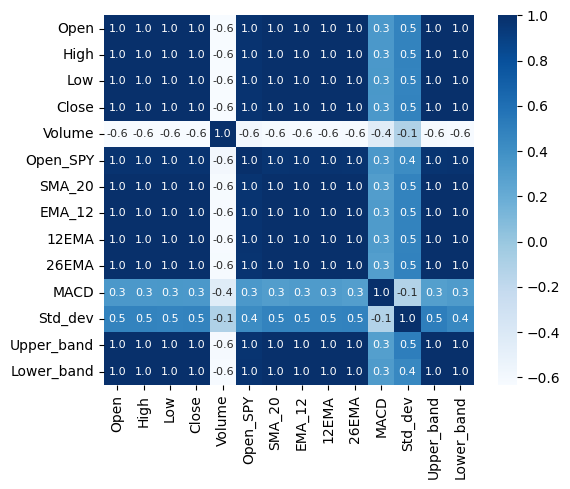

In [11]:
correlation = df.corr()
sns.heatmap(correlation, cbar=True, square=True, fmt= ".1f", annot=True, annot_kws={'size':8},cmap= "Blues")

Data Preprocessing

In [12]:
if df.isnull().values.any():
    print("Data contains missing values. Handling missing values...")
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Open', 'Open_SPY']])


Data Splitting

In [13]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences of data
sequence_length = 60  # Use the past 60 days to predict the next day
train_generator = TimeseriesGenerator(train_data, train_data, length=sequence_length, batch_size=1)
test_generator = TimeseriesGenerator(test_data, test_data, length=sequence_length, batch_size=1)



Model Building

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(2))  # Predicting two values: 'Open' and 'SPY Open'

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  10/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 0.0258

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 7.3710e-04 - val_loss: 9.7655e-04
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 5.5389e-04 - val_loss: 4.2943e-04
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 5.5672e-04 - val_loss: 0.0024
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 4.9976e-04 - val_loss: 0.0076
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 4.6409e-04 - val_loss: 4.4113e-04
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 4.8690e-04 - val_loss: 3.7427e-04
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 4.4752e-04 - val_loss: 4.9975e-04
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 4.5184e-04 - val_loss: 0.0021
Epoch 10/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 3.9284e-04 - val_loss: 3.2761e-04


Predictions and Analysis

581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.3878e-04
Test Loss: 0.0003276107308920473
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


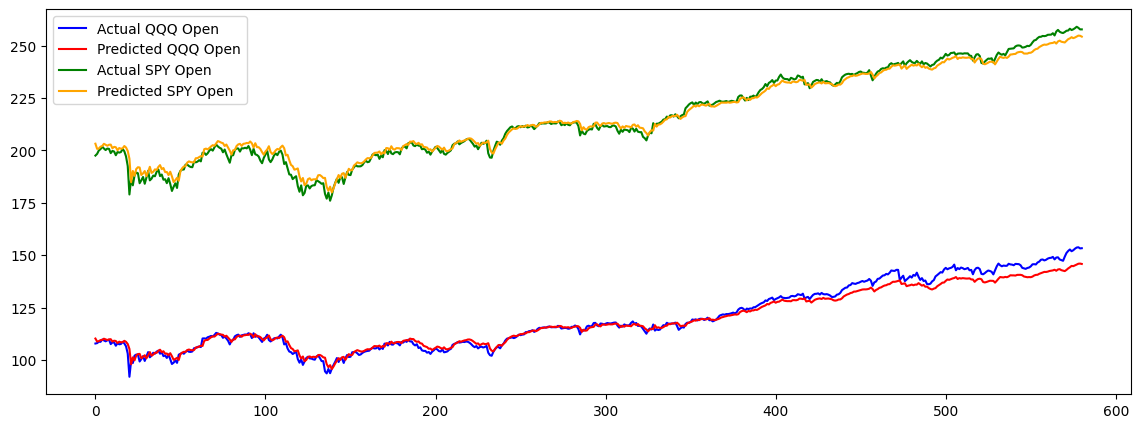

In [15]:

# Evaluate the model
loss = model.evaluate(test_generator, verbose=1)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(test_generator)

# Inverse transform the predictions and actual values to get back to original scale
predictions = scaler.inverse_transform(predictions)
actuals = np.array([x[1] for x in test_generator])
actuals = scaler.inverse_transform(np.concatenate(actuals, axis=0))

# Compare the predictions and actual values
plt.figure(figsize=(14, 5))
plt.plot(actuals[:, 0], color='blue', label='Actual QQQ Open')
plt.plot(predictions[:, 0], color='red', label='Predicted QQQ Open')
plt.plot(actuals[:, 1], color='green', label='Actual SPY Open')
plt.plot(predictions[:, 1], color='orange', label='Predicted SPY Open')
plt.legend()
plt.show()
